In [1]:
data_path = '/Users/aleksandra.rancic/Desktop/dataset'

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [3]:
categories = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

#This code is used to verify the structure of dataset. 

#Initializing lists
category_list = []
images_list = []

#Iterating over categories
for category in categories:
    image_dir = os.path.join(data_path, category, 'images')
    num_images = len(os.listdir(image_dir)) #Counts the number of the files in images folders
    category_list.append(category)
    images_list.append(num_images)
   
data = {'Category': category_list, 'Images': images_list} #Creating a new data frame, dictionary.
df = pd.DataFrame(data)

title = 'Number of Images and Masks for each Category'
print(title)
df.head()

Number of Images and Masks for each Category


Category  Images
0           Normal   10192
1     Lung_Opacity    6012
2  Viral Pneumonia    1345
3            COVID    3616

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.utils.class_weight import compute_class_weight

X = []
y = []

for category in categories: #The code iterates through each category in the 'categories' list
    label = categories.index(category) #For each category, the code assigns a label on the index of the category in the list.
    # 0 is for Normal, 1 for Lung_Opacity,...
    
    image_dir = os.path.join(data_path, category, 'images') #The code constructs the path to the images directory for the current category.

    for filename in os.listdir(image_dir): #The code iterated through each file in the images directory
        #for each image file
        image_path = os.path.join(image_dir, filename)

        with Image.open(image_path) as img: #the image is opened using PIL's Image.open()
            img_array = np.array(img) #the image is converted to a numpy array
            img_array = img_array/255.0 #the pixel values of the image are normalized to the range [0,1]
            img_array = np.expand_dims(img_array, axis = -1)#I added the additional dimension to the image array to indicate 
            #it is a sincgle-channel or grayscale image.

            X.append(img_array)
            y.append(label)

X = np.array(X) #the lists are converted to numpy arrays.
y = np.array(y)

print(f"Shape of X: {X.shape}") # this is a four-dimensional array 
#x represents a batch of 21165 images which height and weight sre 256 each, and each image has channel 1.
print(f"Shape of y: {y.shape}")
#y is a one-dimensional array containing the labels for the images. 

Shape of X: (21165, 256, 256, 1)
Shape of y: (21165,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [7]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (16932, 256, 256, 1), (16932,)
Testing set shape: (4233, 256, 256, 1), (4233,)


In [8]:
"""
compute_class_weight is a function from sklearn.utils.class_weight which computes weights associated with classes 
to handle class imbalance.
The values of y are used to automatically adjust weights inversely proportional to class frequencies.
"""
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(f"Shape of X_train_flat: {X_train_flat.shape}")
print(f"Shape of X_test_flat: {X_test_flat.shape}")
#65526 is a product of 256 and 256.

Shape of X_train_flat: (16932, 65536)
Shape of X_test_flat: (4233, 65536)


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Adjust the output layer units based on your number of classes
])


/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), class_weight=class_weights_dict)


Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 222s 418ms/step - accuracy: 0.5538 - loss: 0.9331 - val_accuracy: 0.8001 - val_loss: 0.4956
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 219s 413ms/step - accuracy: 0.7871 - loss: 0.4470 - val_accuracy: 0.8401 - val_loss: 0.4094
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 218s 412ms/step - accuracy: 0.8240 - loss: 0.3597 - val_accuracy: 0.8512 - val_loss: 0.3774
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 227s 429ms/step - accuracy: 0.8659 - loss: 0.2820 - val_accuracy: 0.8663 - val_loss: 0.3552
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 237s 448ms/step - accuracy: 0.8821 - loss: 0.2364 - val_accuracy: 0.8788 - val_loss: 0.3151
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 236s 445ms/step - accuracy: 0.8948 - loss: 0.2125 - val_accuracy: 0.8580 - val_loss: 0.3960
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 237s 447ms/step - accuracy: 0.8985 - loss: 0.1983 - val_accuracy: 0.8868 - val_loss: 0.3112
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 236s 446ms/step - accuracy: 0.9202 -

In [16]:
import pickle
from tensorflow.keras.models import load_model

# Load the model
model = load_model('cnn_model.keras')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Load the class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights_dict = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)


/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")



133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.8745 - loss: 0.8223
Test Accuracy: 0.8847153186798096


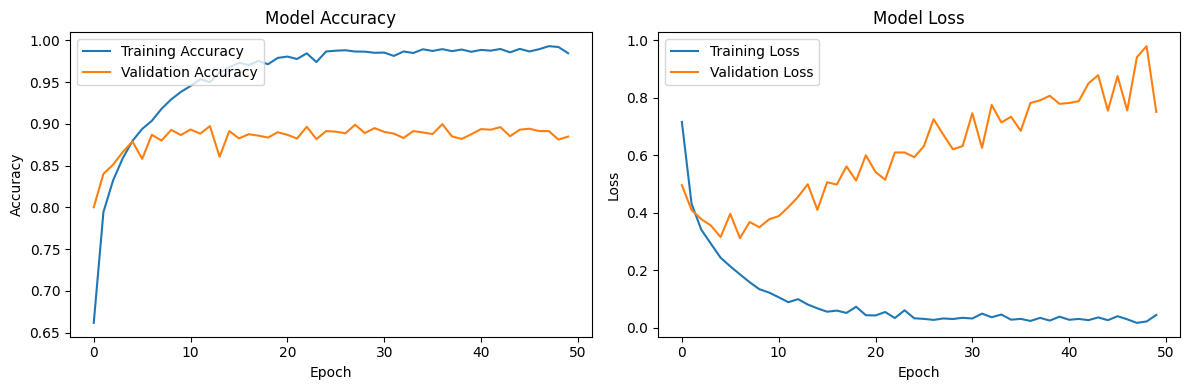

In [19]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary after loading from the pickle file
plt.figure(figsize=(12, 4))

# Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Model Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step


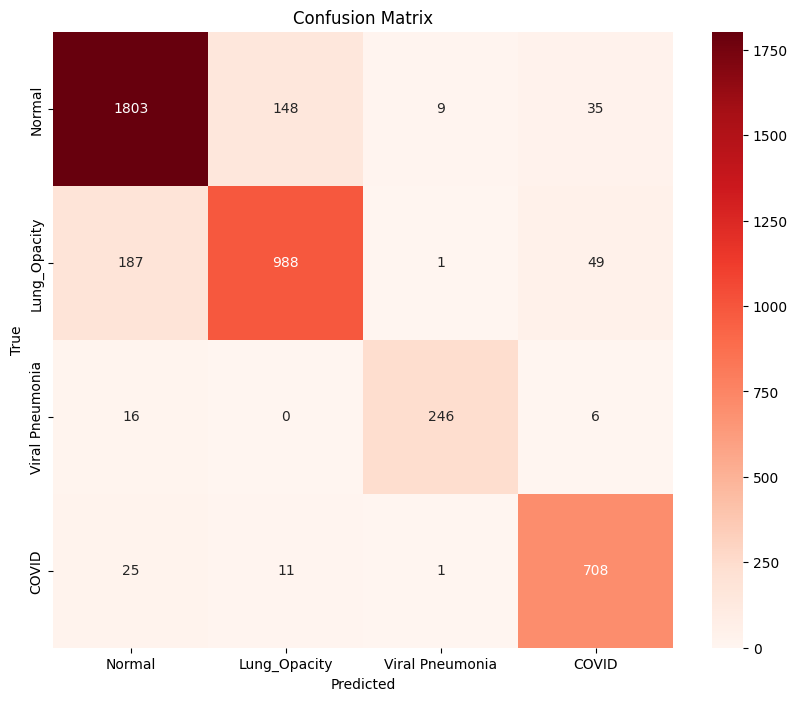

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the labels of the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=categories))


                 precision    recall  f1-score   support

         Normal       0.89      0.90      0.90      1995
   Lung_Opacity       0.86      0.81      0.83      1225
Viral Pneumonia       0.96      0.92      0.94       268
          COVID       0.89      0.95      0.92       745

       accuracy                           0.88      4233
      macro avg       0.90      0.89      0.90      4233
   weighted avg       0.88      0.88      0.88      4233



133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step


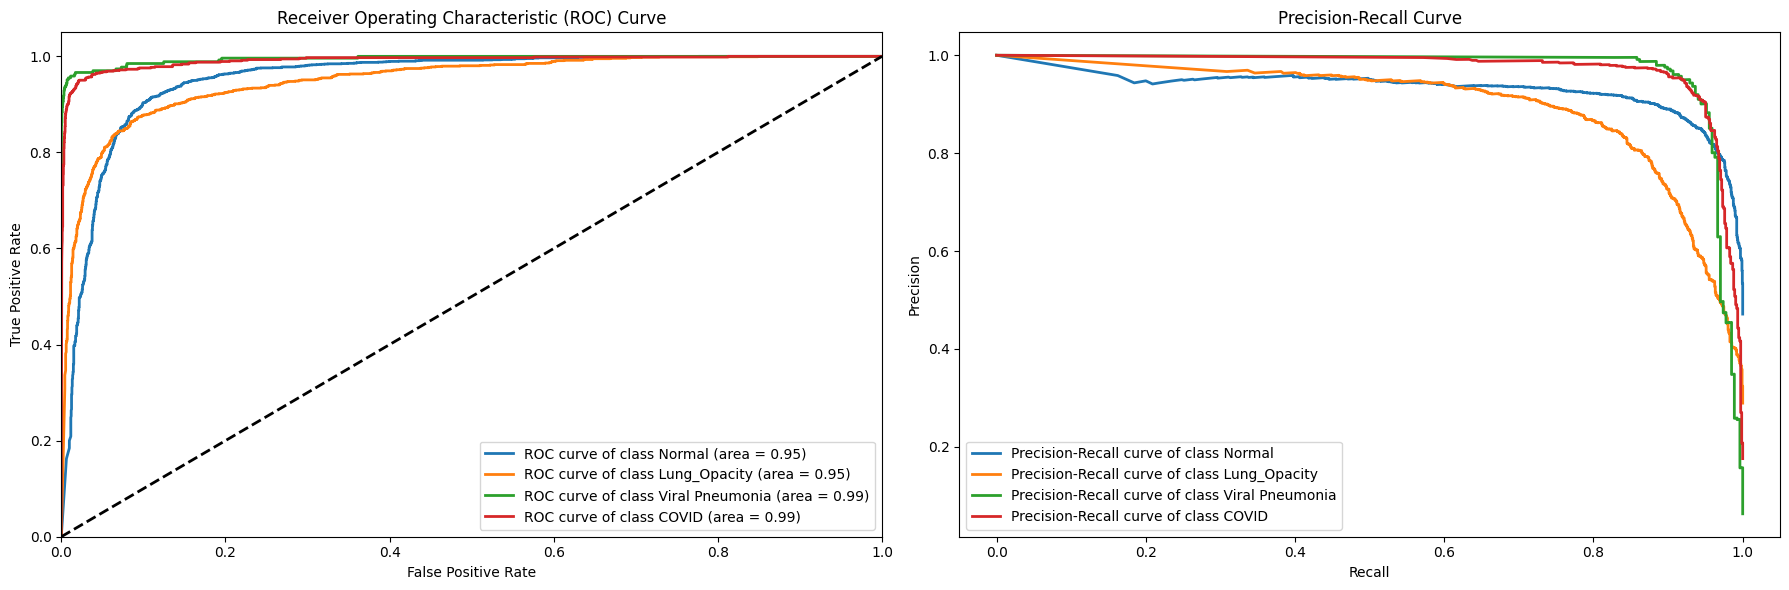

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=range(len(categories)))

y_pred_prob = model.predict(X_test)

plt.figure(figsize=(18, 6))

#ROC curve for each class
plt.subplot(1, 2, 1)
for i in range(len(categories)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {categories[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-Recall curve for each class
plt.subplot(1, 2, 2)
for i in range(len(categories)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve of class {categories[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


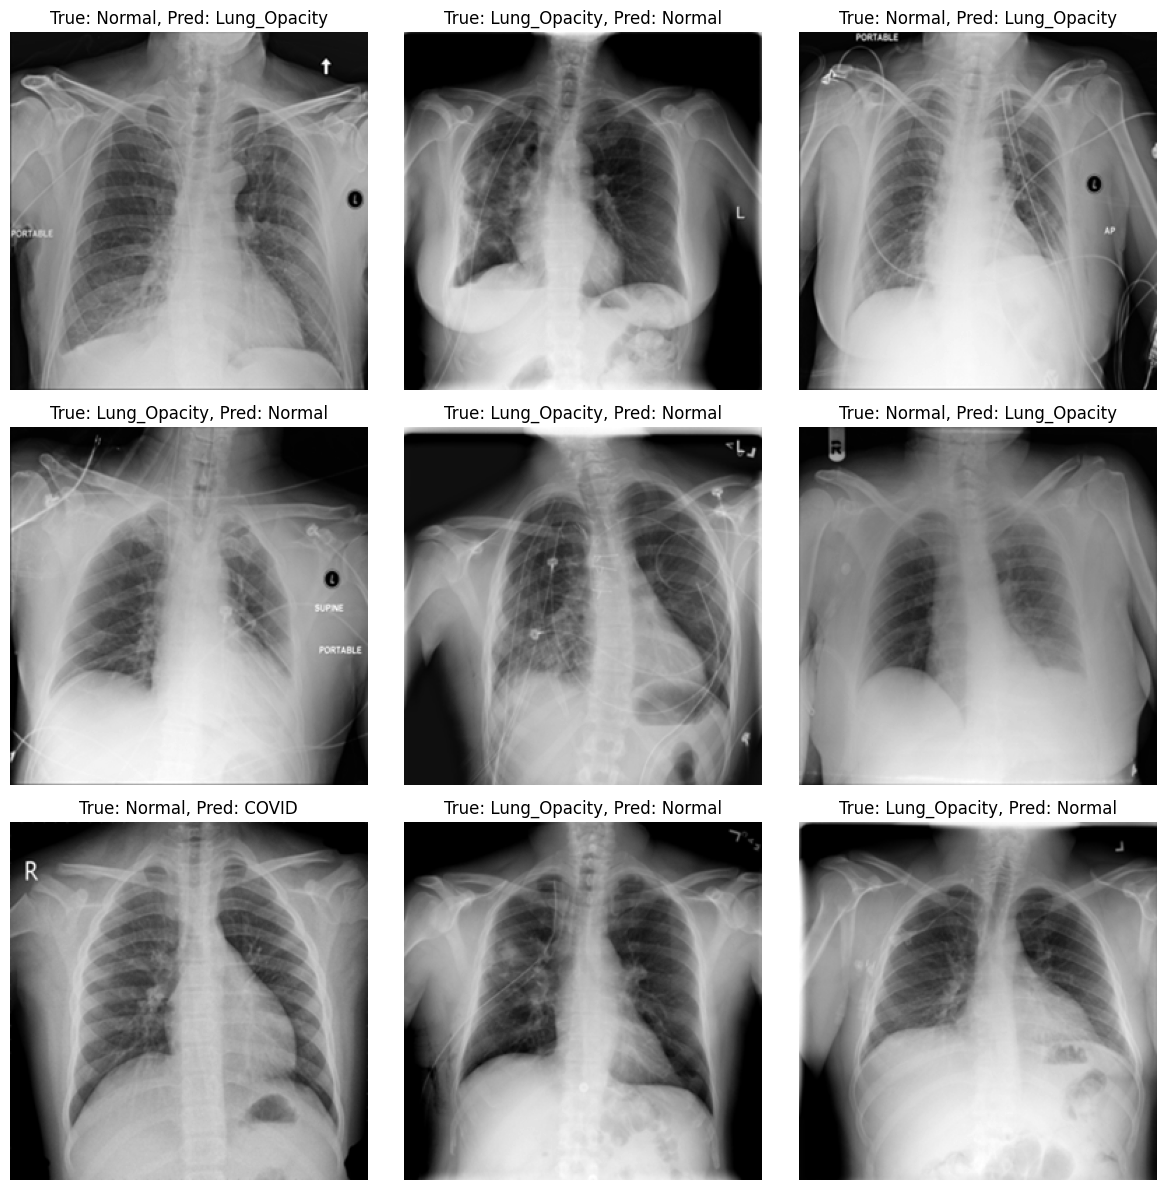

In [26]:
import numpy as np

# Get indices of misclassified images
misclassified_idx = np.where(y_pred != y_test)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_idx[:9]):  # Display the first 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].reshape(256, 256), cmap='gray')
    plt.title(f'True: {categories[y_test[idx]]}, Pred: {categories[y_pred[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
X_train_reshaped = X_train_flat_scaled.reshape(-1, 256, 256, 1)
X_test_reshaped = X_test_flat_scaled.reshape(-1, 256, 256, 1)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')  # Assuming you have 4 categories
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()


/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
history = cnn_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 200s 376ms/step - accuracy: 0.6819 - loss: 1.0156 - val_accuracy: 0.8356 - val_loss: 0.4360
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 192s 362ms/step - accuracy: 0.8549 - loss: 0.4044 - val_accuracy: 0.8519 - val_loss: 0.4174
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 192s 363ms/step - accuracy: 0.8972 - loss: 0.2805 - val_accuracy: 0.8500 - val_loss: 0.4013
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 193s 364ms/step - accuracy: 0.9295 - loss: 0.1889 - val_accuracy: 0.8486 - val_loss: 0.4572
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 193s 363ms/step - accuracy: 0.9573 - loss: 0.1187 - val_accuracy: 0.8601 - val_loss: 0.5575
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 193s 363ms/step - accuracy: 0.9714 - loss: 0.0833 - val_accuracy: 0.8687 - val_loss: 0.5625
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 193s 364ms/step - accuracy: 0.9834 - loss: 0.0462 - val_accuracy: 0.8509 - val_loss: 0.8046
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 193s 364ms/step - accuracy: 0.9877 -

In [28]:
import pickle
from tensorflow.keras.models import save_model

# Save the model
cnn_model.save('cnn_model.keras') 

# Save the training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [29]:
import pickle
from tensorflow.keras.models import load_model

# Load the model
cnn_model = load_model('cnn_model.keras')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)


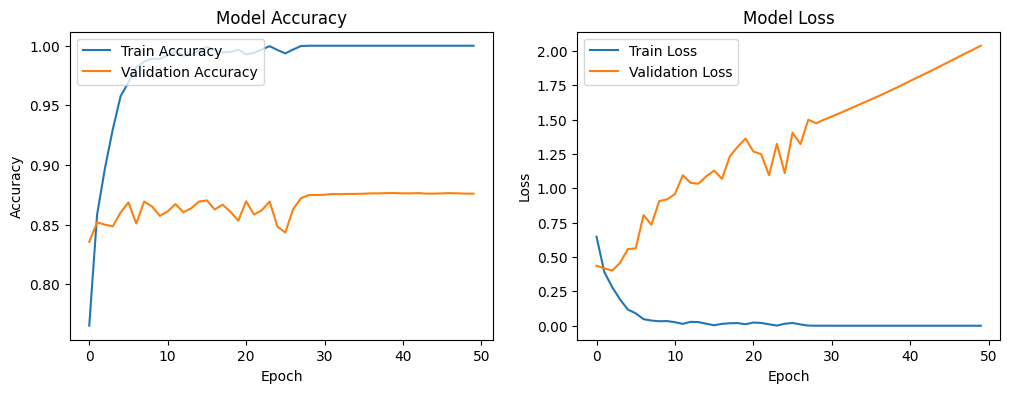

In [31]:
import matplotlib.pyplot as plt
import pickle

# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plotting
plt.figure(figsize=(12, 4))

# Validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


In [32]:
test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.8683 - loss: 2.2159
Test accuracy: 0.8759744763374329
Test loss: 2.0367908477783203


133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step


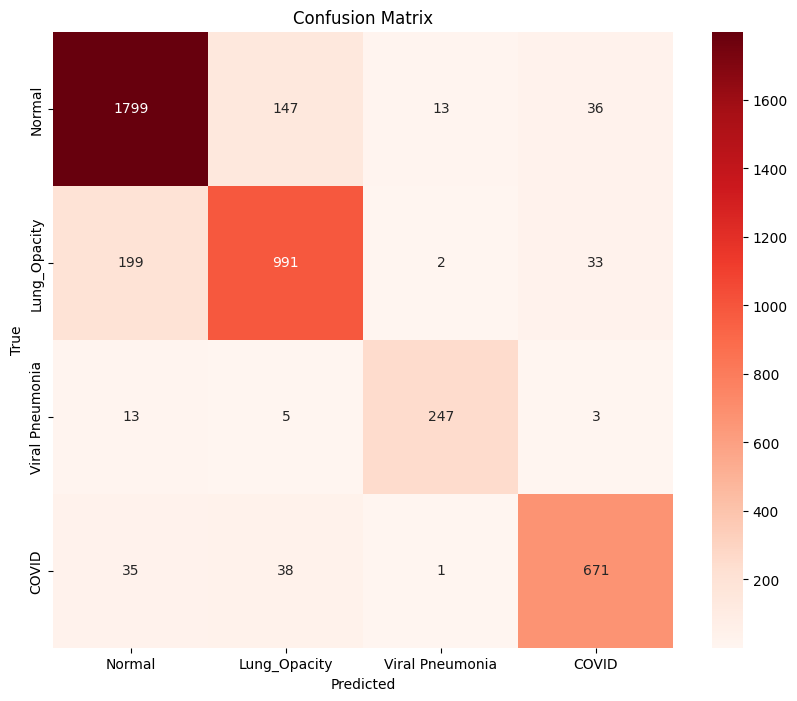

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the labels of the test set
y_pred = cnn_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [34]:
from sklearn.metrics import classification_report

# Classification report
report = classification_report(y_test, y_pred_classes, target_names=categories)
print(report)


                 precision    recall  f1-score   support

         Normal       0.88      0.90      0.89      1995
   Lung_Opacity       0.84      0.81      0.82      1225
Viral Pneumonia       0.94      0.92      0.93       268
          COVID       0.90      0.90      0.90       745

       accuracy                           0.88      4233
      macro avg       0.89      0.88      0.89      4233
   weighted avg       0.88      0.88      0.88      4233



133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step


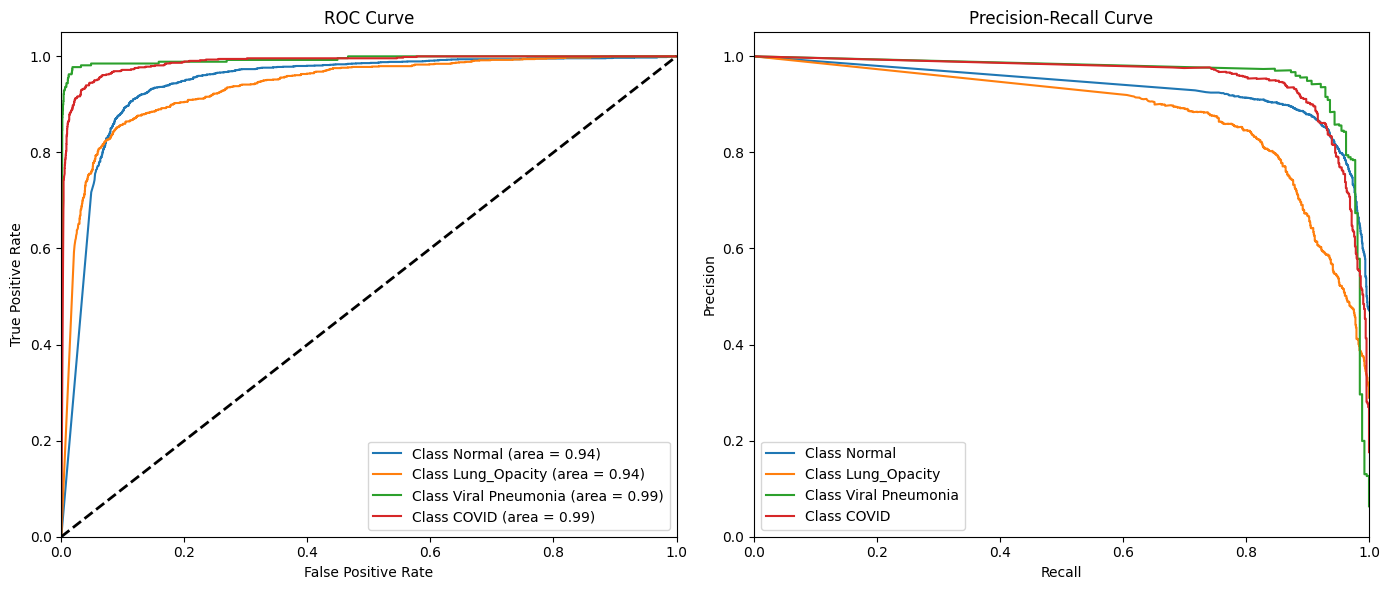

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=range(len(categories)))
y_pred_prob = cnn_model.predict(X_test_reshaped)

plt.figure(figsize=(14, 6))

# ROC curve
plt.subplot(1, 2, 1)
for i in range(len(categories)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {categories[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve
plt.subplot(1, 2, 2)
for i in range(len(categories)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {categories[i]}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


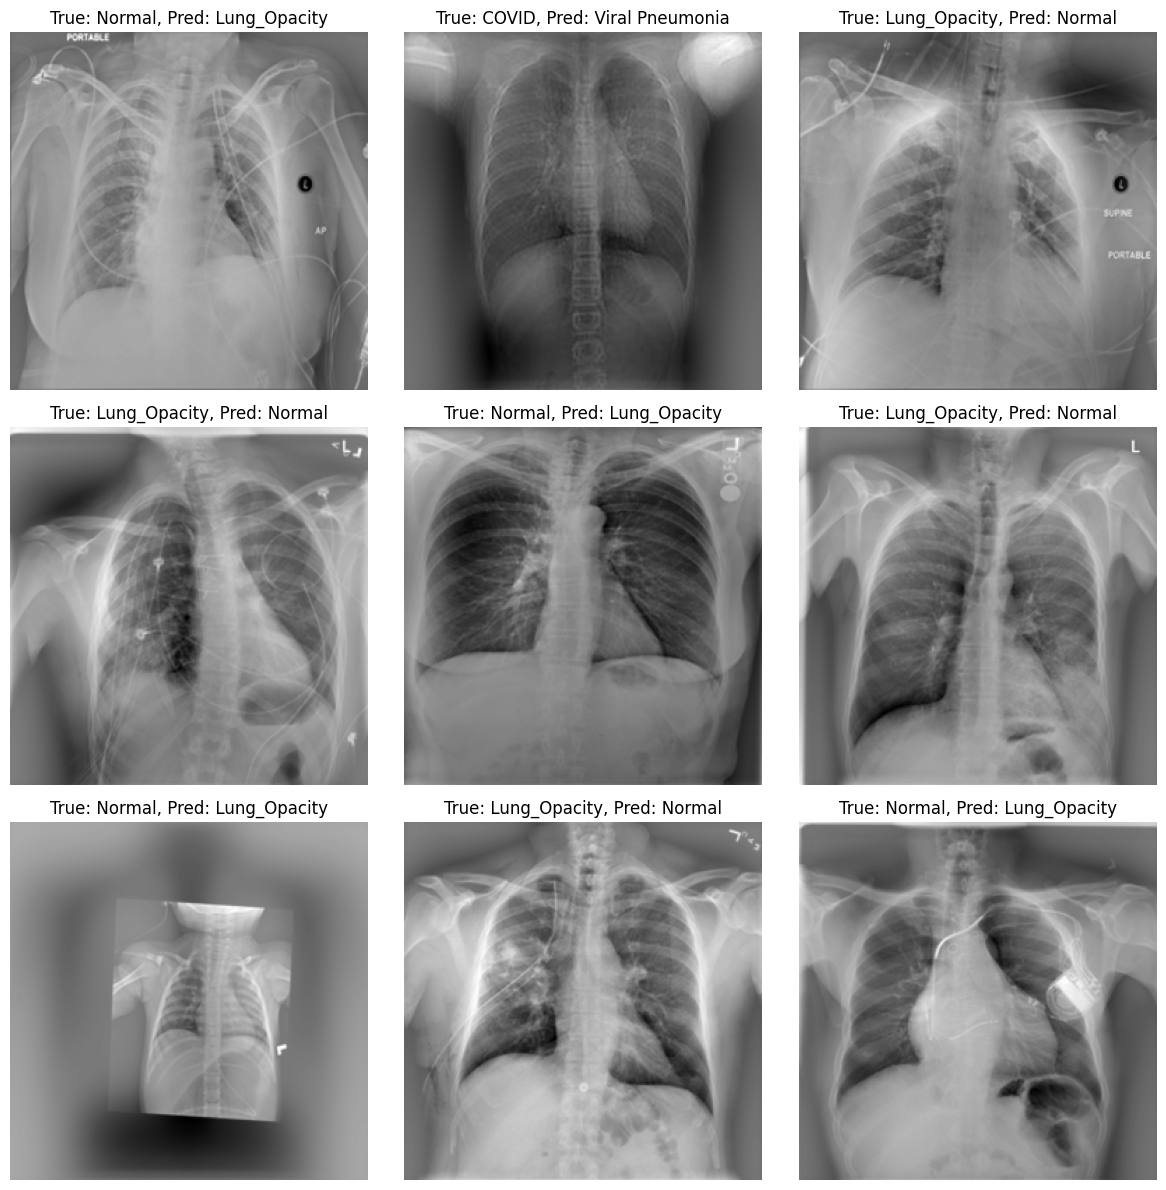

In [36]:
incorrect_indices = np.where(y_pred_classes != y_test)[0]

# Display some incorrect predictions
plt.figure(figsize=(12, 12))
for i, incorrect_index in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_reshaped[incorrect_index].reshape(256, 256), cmap='gray')
    plt.title(f"True: {categories[y_test[incorrect_index]]}, Pred: {categories[y_pred_classes[incorrect_index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


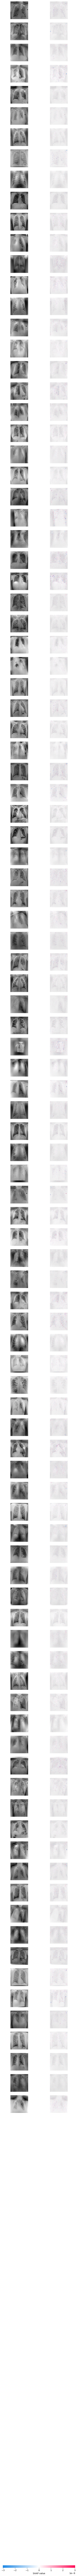

In [38]:
#Interpretabilty

import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

X_sample = X_test_reshaped[:100]

explainer = shap.GradientExplainer(cnn_model, X_sample)
shap_values = explainer.shap_values(X_sample)

shap.image_plot(shap_values, X_sample)

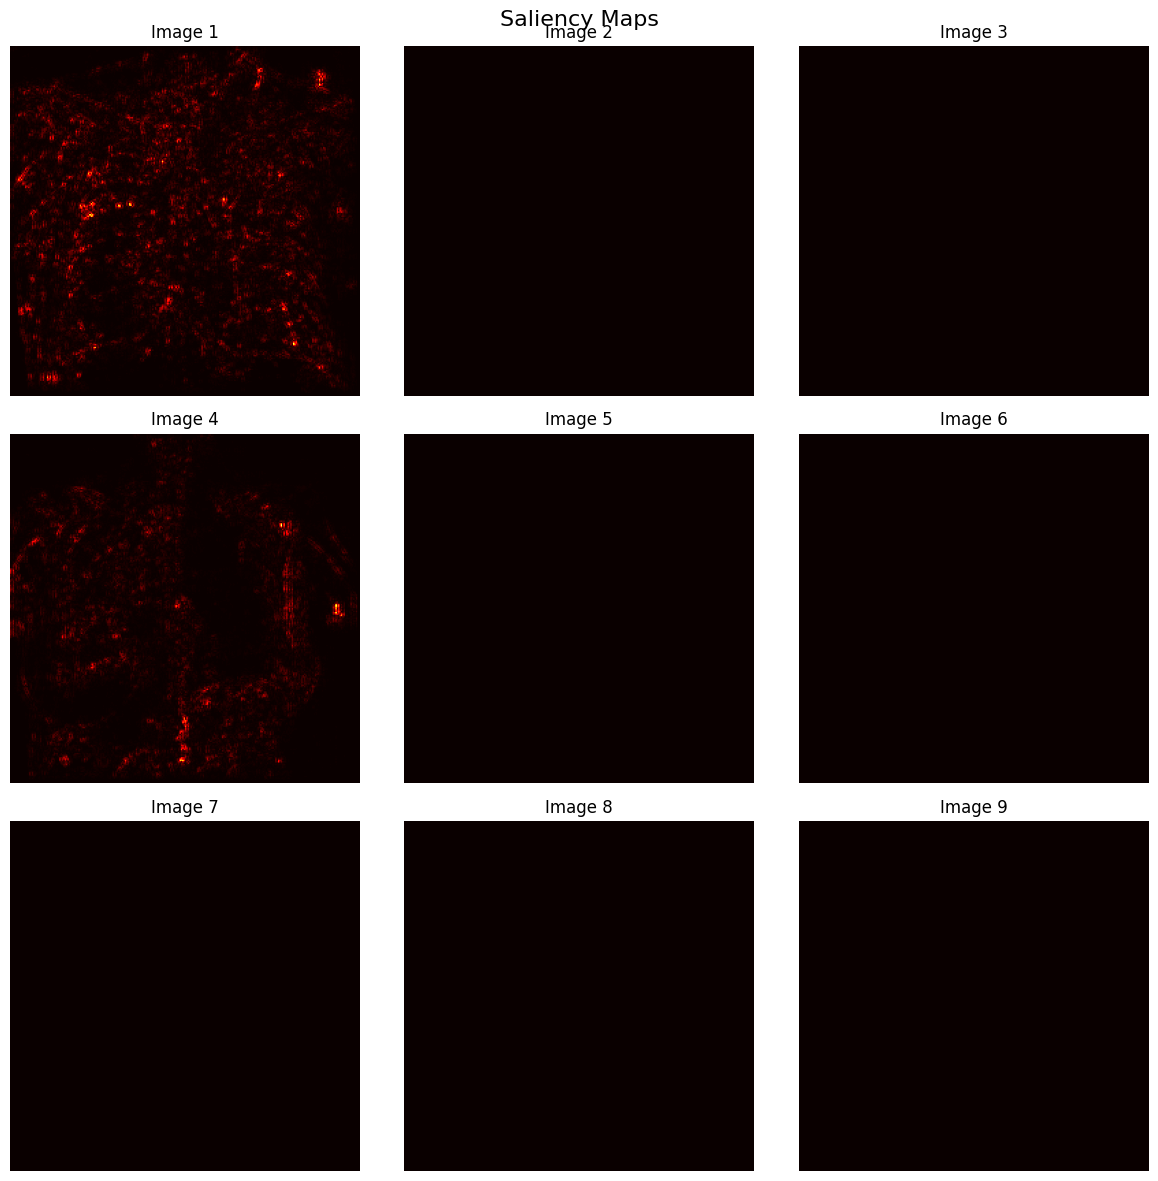

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_maps(model, X):
    X = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
    grads = tape.gradient(predictions, X)
    saliency = np.max(np.abs(grads), axis=-1)
    return saliency

# Select 9 samples from the test set
X_sample = X_test_reshaped[:9]
saliency_maps = compute_saliency_maps(cnn_model, X_sample)

# Create a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Saliency Maps', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(saliency_maps):
        ax.imshow(saliency_maps[i], cmap='hot')
        ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()



In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape=(256, 256, 1), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Adding dropout for regularization
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN model
cnn_model = create_cnn_model()

# Display the model summary
cnn_model.summary()

# Train the model
history = cnn_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))


/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,916 (56.61 MB)

 Trainable params: 14,838,916 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 199s 374ms/step - accuracy: 0.6658 - loss: 0.9379 - val_accuracy: 0.8434 - val_loss: 0.4388
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 197s 372ms/step - accuracy: 0.8179 - loss: 0.4827 - val_accuracy: 0.8552 - val_loss: 0.3799
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 194s 366ms/step - accuracy: 0.8650 - loss: 0.3672 - val_accuracy: 0.8734 - val_loss: 0.3446
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 201s 380ms/step - accuracy: 0.8868 - loss: 0.3017 - val_accuracy: 0.8677 - val_loss: 0.3637
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 198s 374ms/step - accuracy: 0.9102 - loss: 0.2435 - val_accuracy: 0.8729 - val_loss: 0.3625
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 202s 381ms/step - accuracy: 0.9229 - loss: 0.2013 - val_accuracy: 0.8750 - val_loss: 0.3547
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 198s 374ms/step - accuracy: 0.9346 - loss: 0.1790 - val_accuracy: 0.8805 - val_loss: 0.3960
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 196s 370ms/step - accuracy: 0.9527 -

In [25]:
import pickle
cnn_model.save('cnn_model.h5')

# Save the training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Load the model architecture and weights
loaded_model = tf.keras.models.load_model('cnn_model.h5')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Verify the loaded history
print(loaded_history)

{'accuracy': [0.734821617603302, 0.826364278793335, 0.8629813194274902, 0.886250913143158, 0.9092251062393188, 0.9239310026168823, 0.9363335967063904, 0.94997638463974, 0.9536380767822266, 0.9596621990203857, 0.967399001121521, 0.9657453298568726, 0.969525158405304, 0.9757264256477356, 0.9745452404022217, 0.975135862827301, 0.9812189936637878, 0.9793881177902222, 0.9805693626403809, 0.9796834588050842, 0.9845263361930847, 0.9842901229858398, 0.982577383518219, 0.9842310547828674, 0.9818096160888672, 0.9851169586181641, 0.9874202609062195, 0.9837585687637329, 0.984171986579895, 0.9876565337181091, 0.9863572120666504, 0.9871249794960022, 0.988837718963623, 0.9877746105194092, 0.9866524934768677, 0.9894282817840576, 0.9877746105194092, 0.9880699515342712, 0.9897236227989197, 0.9893102049827576, 0.9890148639678955, 0.9890739321708679, 0.9909048080444336, 0.9902551174163818, 0.9914953708648682, 0.9913182258605957, 0.9901370406150818, 0.9910229444503784, 0.9914363622665405, 0.991318225860595

In [ ]:
import tensorflow as tf
import pickle

# Load the model architecture and weights
loaded_model = tf.keras.models.load_model('cnn_model.h5')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Verify the loaded history
print(loaded_history)


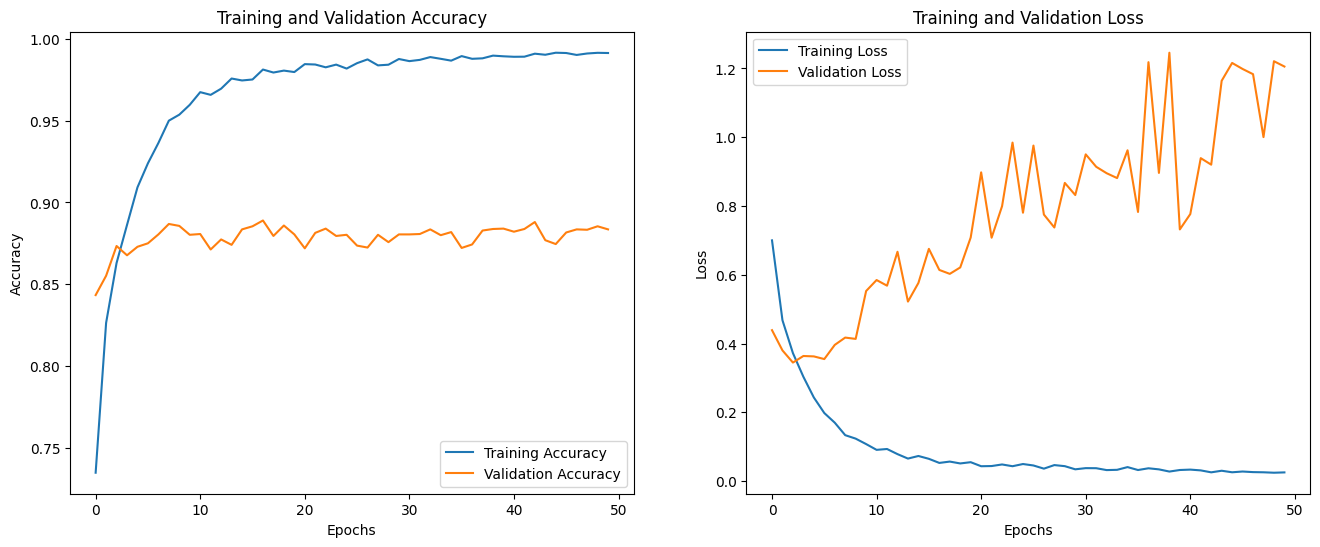

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot training and validation accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

# Plot training and validation loss
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step


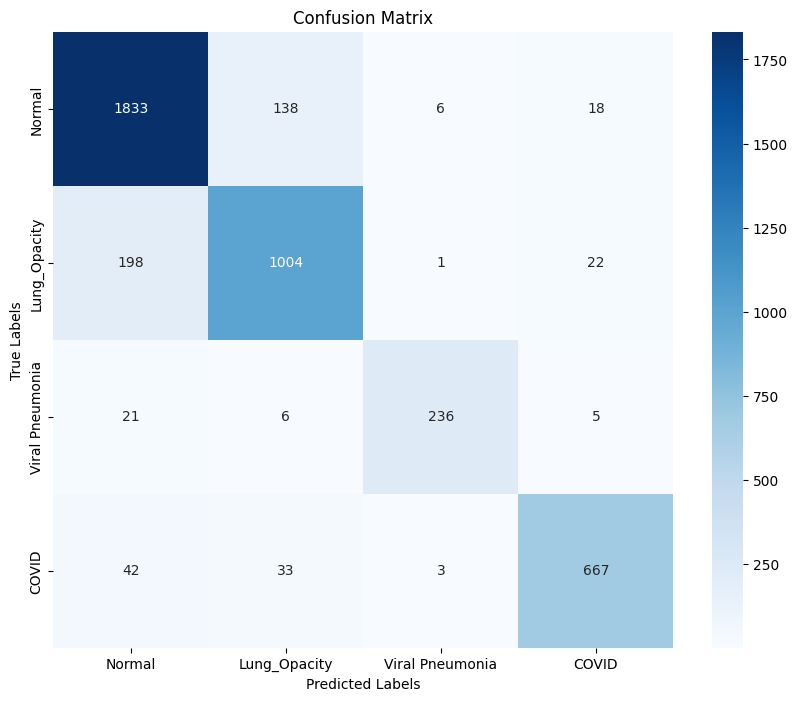

In [14]:
# Predict the classes on the test set
y_pred = cnn_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID'], yticklabels=['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step


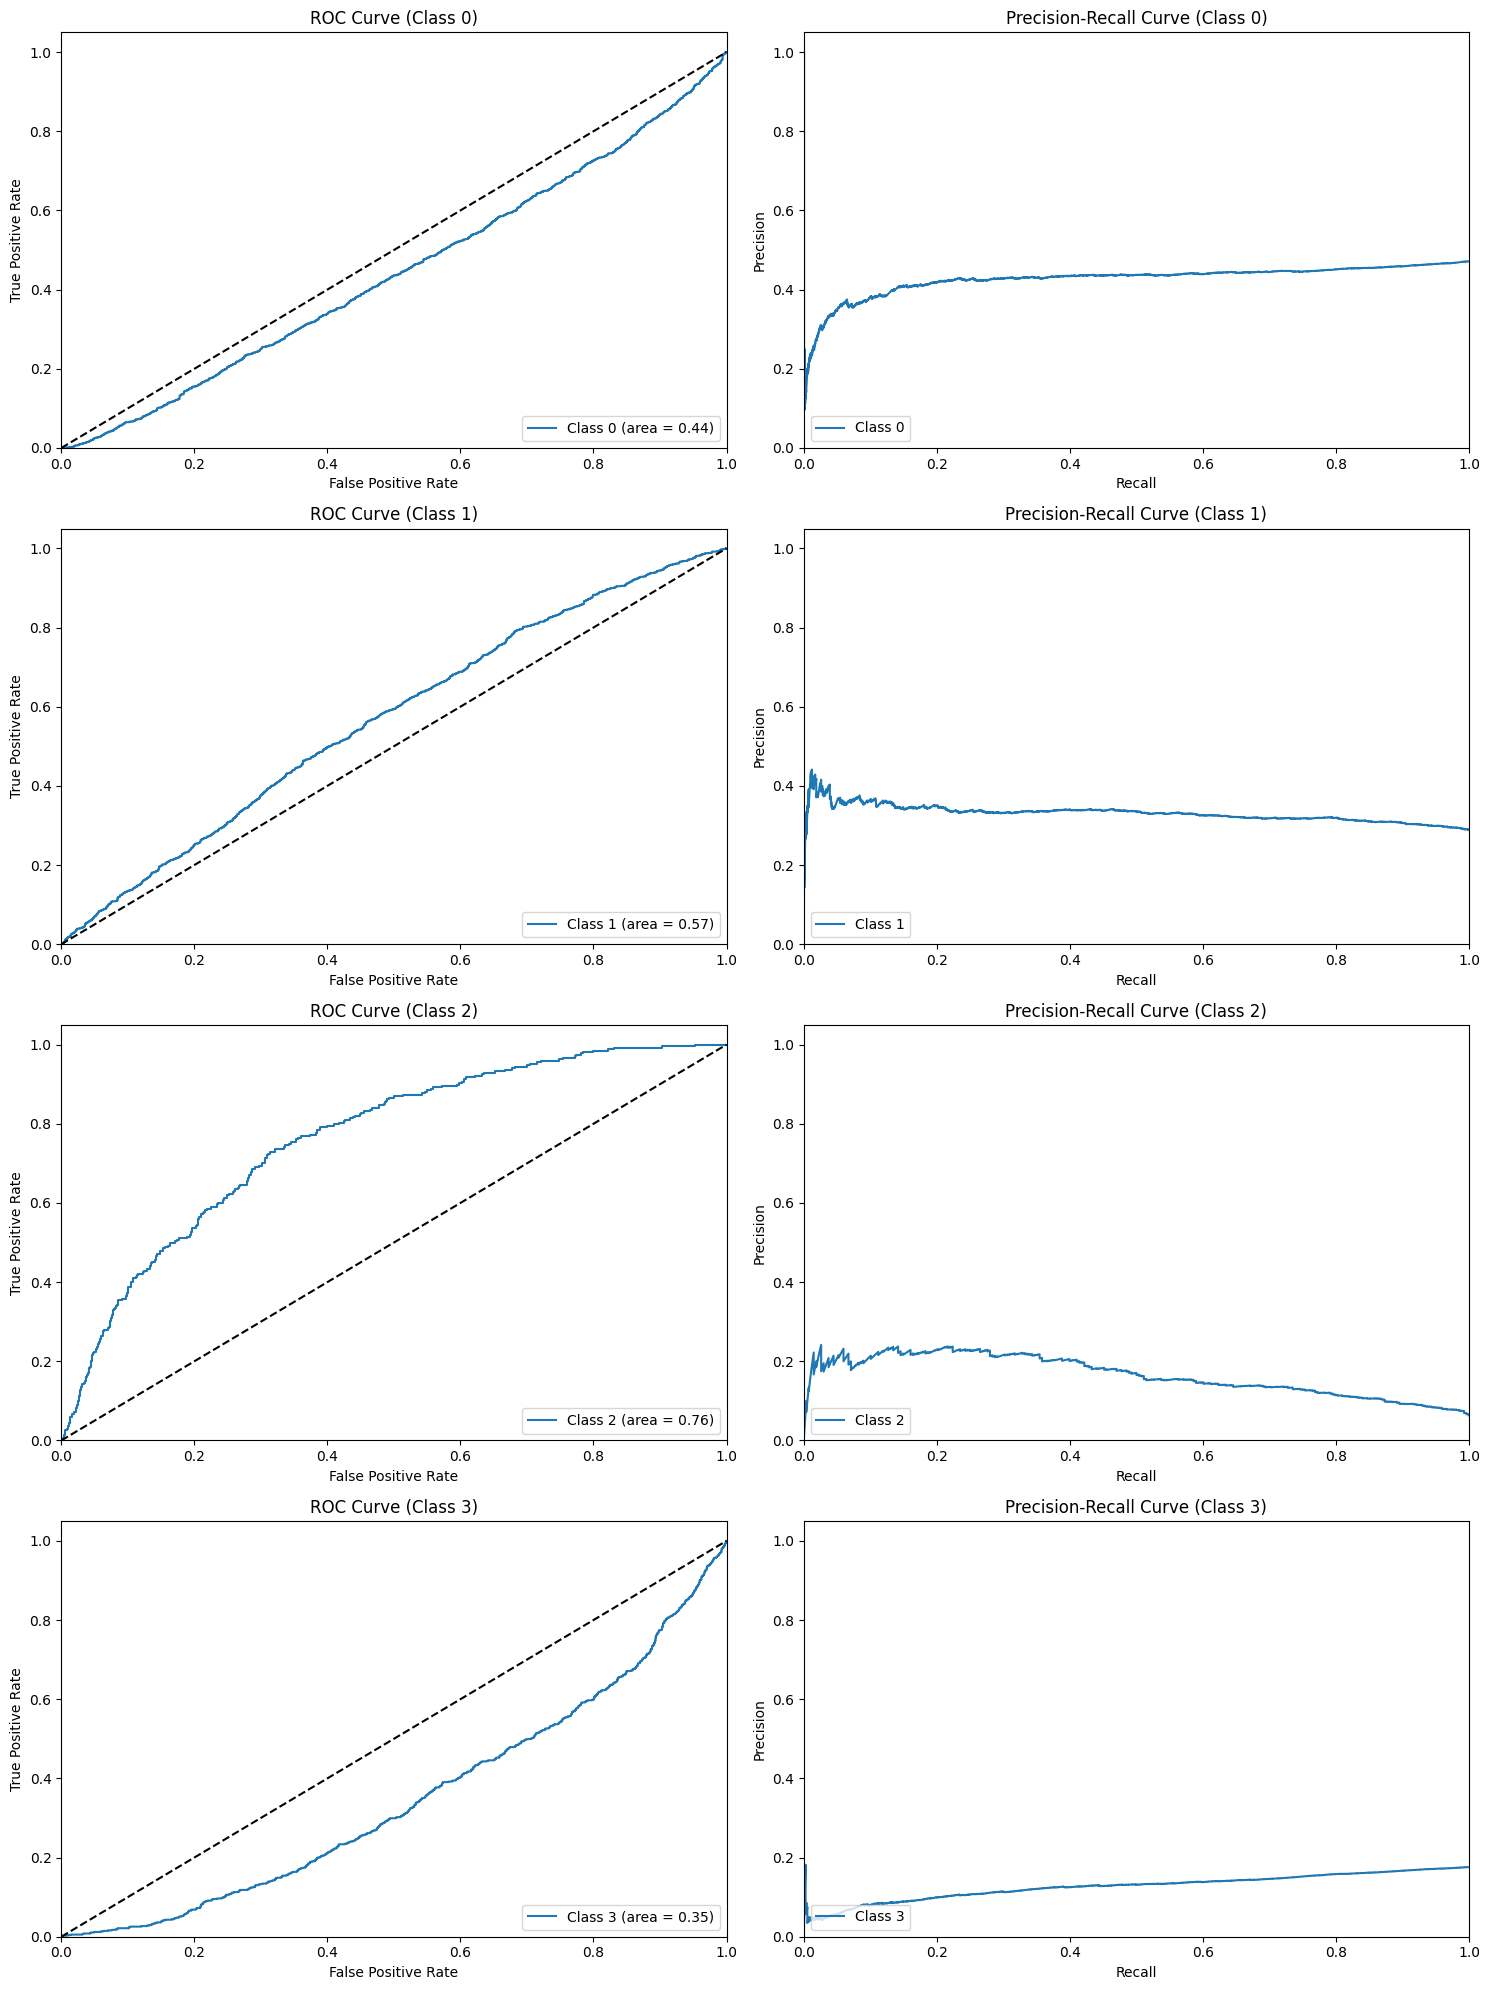

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Generate predictions
y_pred_probs = cnn_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# One-hot encode the true labels for multi-class ROC and PR curve
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Plot ROC and PR curves for each class
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for i in range(4):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    axs[i, 0].plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')
    axs[i, 0].plot([0, 1], [0, 1], 'k--')
    axs[i, 0].set_xlim([0.0, 1.0])
    axs[i, 0].set_ylim([0.0, 1.05])
    axs[i, 0].set_xlabel('False Positive Rate')
    axs[i, 0].set_ylabel('True Positive Rate')
    axs[i, 0].set_title(f'ROC Curve (Class {i})')
    axs[i, 0].legend(loc="lower right")

    # Compute Precision-Recall curve for each class
    precision, recall, _ = precision_recall_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
    
    axs[i, 1].plot(recall, precision, label=f'Class {i}')
    axs[i, 1].set_xlim([0.0, 1.0])
    axs[i, 1].set_ylim([0.0, 1.05])
    axs[i, 1].set_xlabel('Recall')
    axs[i, 1].set_ylabel('Precision')
    axs[i, 1].set_title(f'Precision-Recall Curve (Class {i})')
    axs[i, 1].legend(loc="lower left")

plt.tight_layout()
plt.show()


In [15]:
# Print the classification report
class_report = classification_report(y_test, y_pred_classes, target_names=['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID'])
print("Classification Report:\n")
print(class_report)


Classification Report:

                 precision    recall  f1-score   support

         Normal       0.88      0.92      0.90      1995
   Lung_Opacity       0.85      0.82      0.83      1225
Viral Pneumonia       0.96      0.88      0.92       268
          COVID       0.94      0.90      0.92       745

       accuracy                           0.88      4233
      macro avg       0.91      0.88      0.89      4233
   weighted avg       0.88      0.88      0.88      4233



In [ ]:
#Prvih 10 celija ako se restartovao kernel i ove ispod (8 celija ispod ove)

In [11]:
from sklearn.model_selection import train_test_split

X_train_flat_scaled, X_val_flat_scaled, y_train, y_val = train_test_split(
    X_train_flat_scaled, y_train, test_size=0.2, random_state=123)

X_train_reshaped = X_train_flat_scaled.reshape(-1, 256, 256, 1)
X_val_reshaped = X_val_flat_scaled.reshape(-1, 256, 256, 1)
X_test_reshaped = X_test_flat_scaled.reshape(-1, 256, 256, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def create_cnn_model(input_shape=(256, 256, 1), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
# Define the image shape
image_shape = (256, 256, 1)  

# Create the CNN model
cnn_model = create_cnn_model(input_shape=image_shape)

# Display the model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,665,476 (25.43 MB)

 Trainable params: 6,664,772 (25.42 MB)

 Non-trainable params: 704 (2.75 KB)

In [19]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model_with_bn.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
cnn_model.save('cnn_model_with_bn.keras')

# Save the training history
with open('training_history_with_bn.pkl', 'wb') as f:
    pickle.dump(history.history, f)



Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 281s 662ms/step - accuracy: 0.9360 - loss: 0.6411 - val_accuracy: 0.8344 - val_loss: 1.0325
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 265s 626ms/step - accuracy: 0.9403 - loss: 0.6337 - val_accuracy: 0.9011 - val_loss: 0.7712
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 274s 645ms/step - accuracy: 0.9490 - loss: 0.6068 - val_accuracy: 0.9005 - val_loss: 0.7732
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 271s 639ms/step - accuracy: 0.9488 - loss: 0.5696 - val_accuracy: 0.8931 - val_loss: 0.7602
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 276s 651ms/step - accuracy: 0.9511 - loss: 0.5671 - val_accuracy: 0.8854 - val_loss: 0.8784
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 275s 649ms/step - accuracy: 0.9529 - loss: 0.5894 - val_accuracy: 0.8996 - val_loss: 0.7576
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 269s 634ms/step - accuracy: 0.9617 - loss: 0.5414 - val_accuracy: 0.8990 - val_loss: 0.8267
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 262s 618ms/step - accuracy: 0.9563 -

In [22]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Load the model
loaded_model = tf.keras.models.load_model('cnn_model_with_bn.h5')

# Load the training history
with open('training_history_with_bn.pkl', 'rb') as f:
    loaded_history = pickle.load(f)


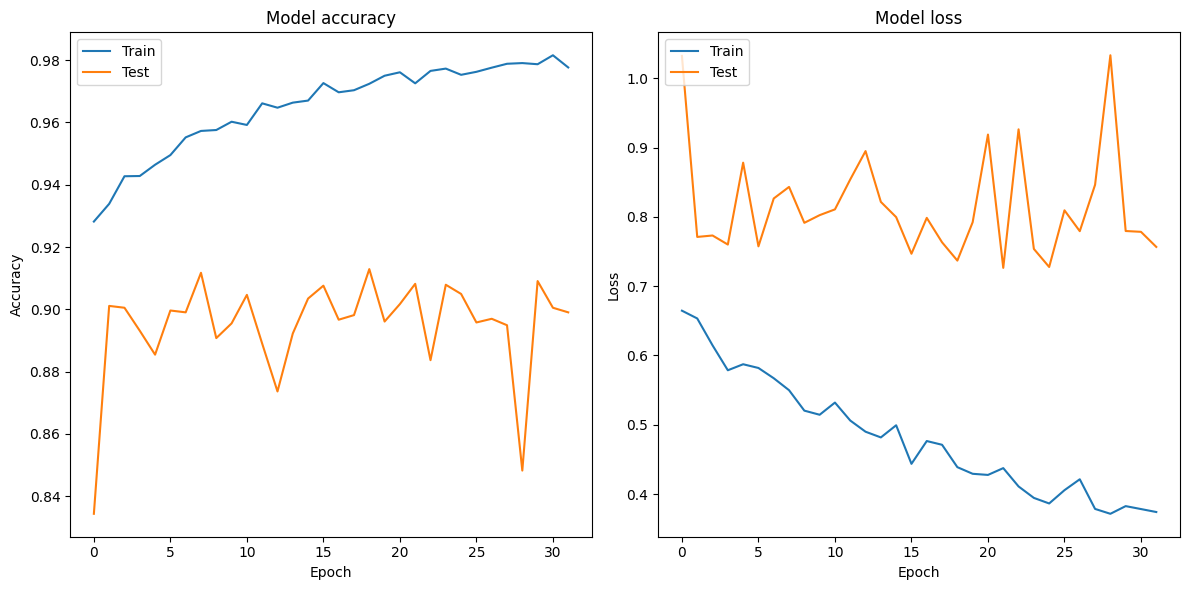

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step


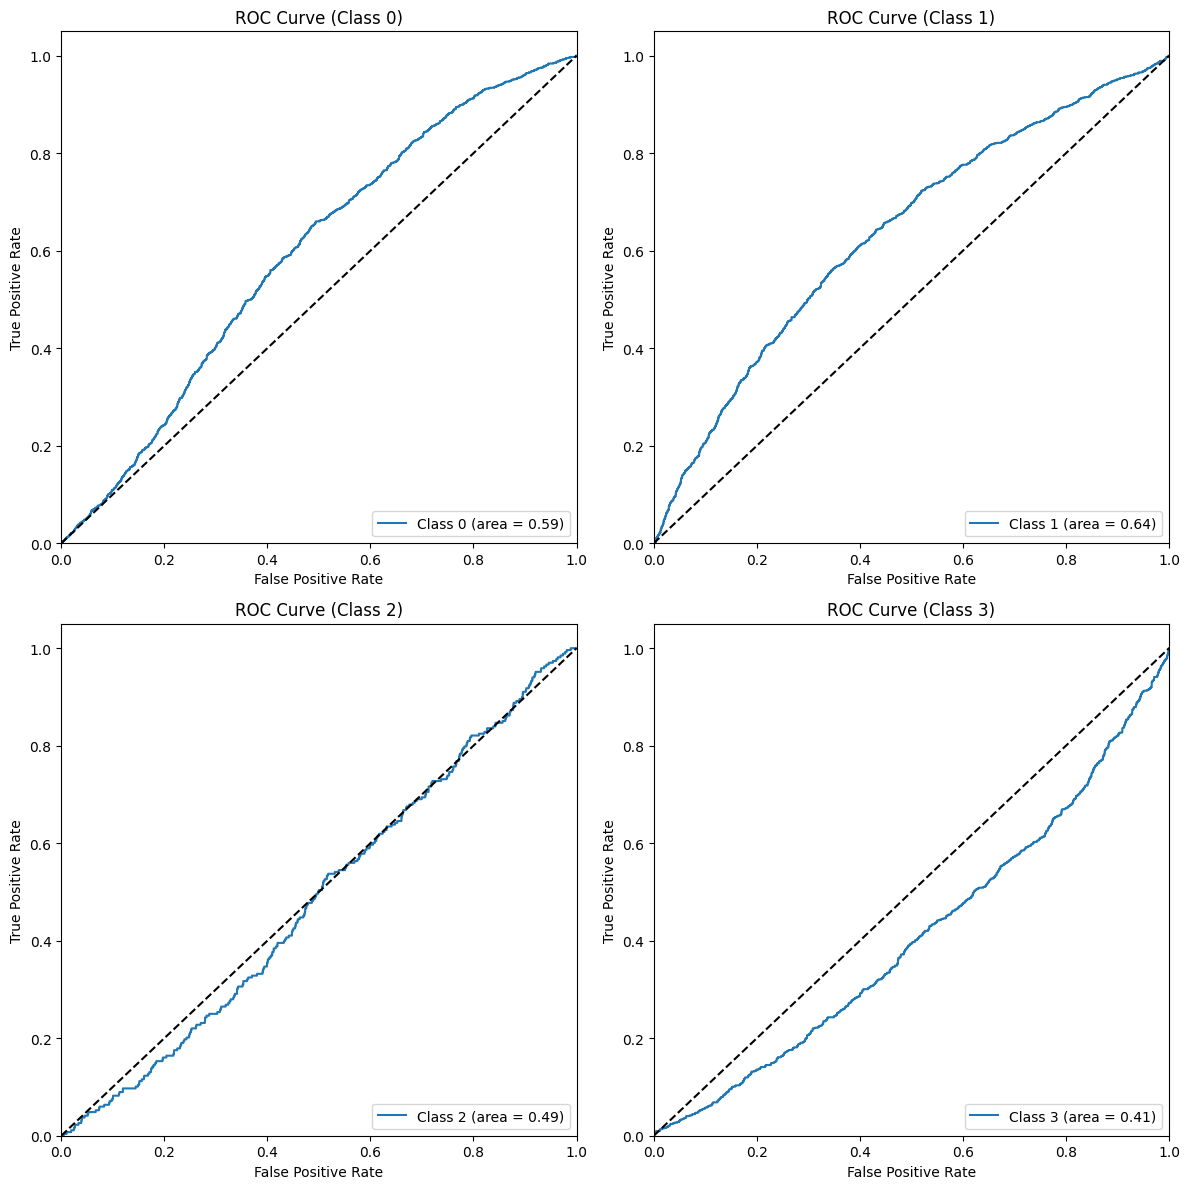

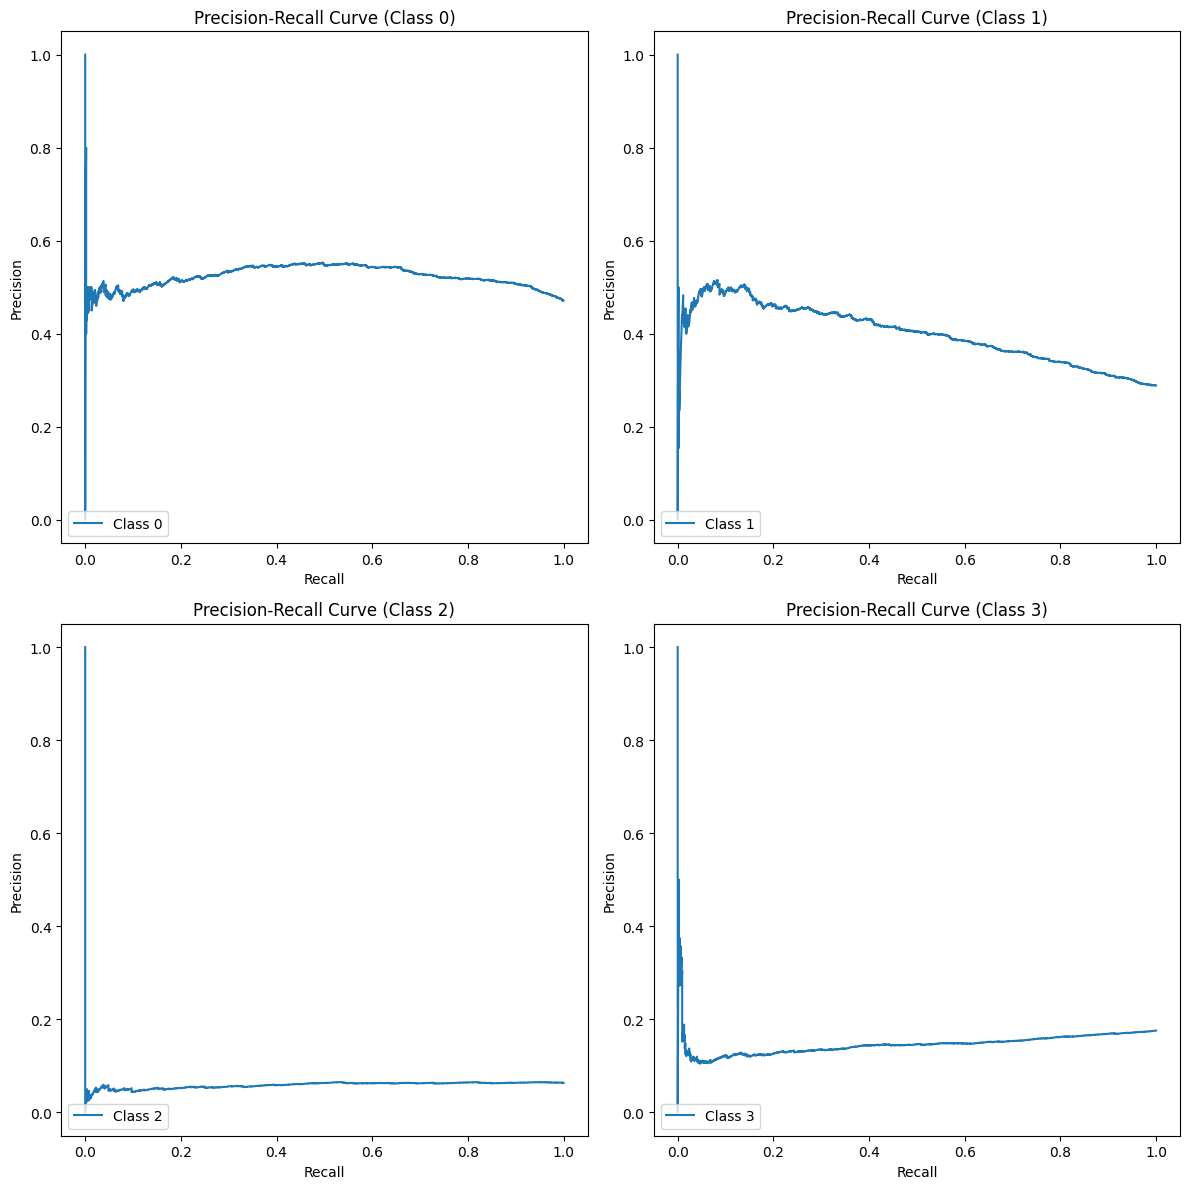

In [24]:
# Generate predictions
y_pred_probs = loaded_model.predict(X_test_reshaped)
y_pred_classes = tf.argmax(y_pred_probs, axis=1)

# One-hot encode the true labels for multi-class RO C and PR curve
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Plot ROC and PR curves for each class
plt.figure(figsize=(12, 12))

for i in range(4):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Class {i})')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))

for i in range(4):
    # Compute Precision-Recall curve for each class
    precision, recall, _ = precision_recall_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
    
    plt.subplot(2, 2, i + 1)
    plt.plot(recall, precision, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step


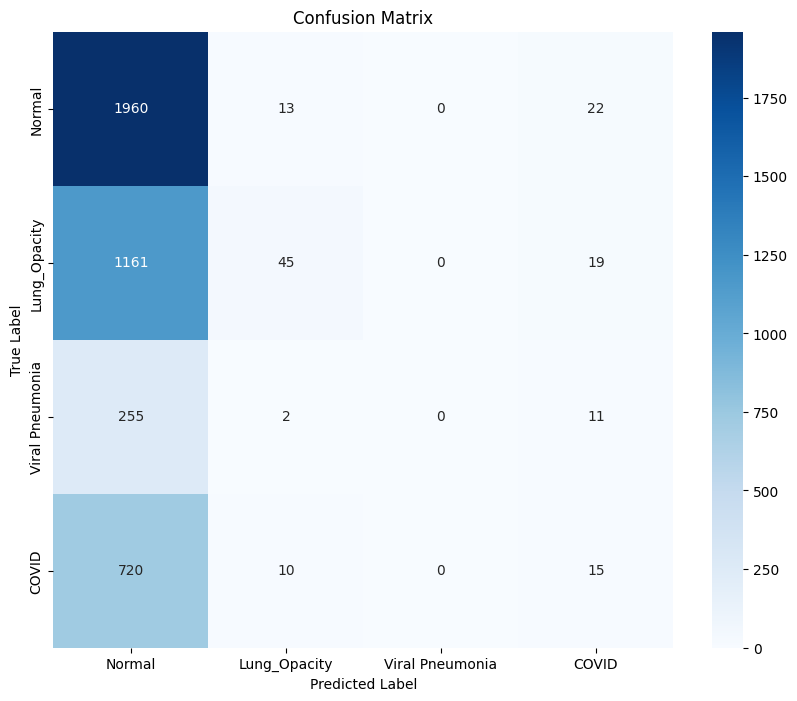

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Generate predictions
y_pred_probs = loaded_model.predict(X_test_reshaped)
y_pred_classes = tf.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [84]:
import os
import shutil
import random

def split_data(source_dir, train_dir, val_dir, train_ratio=0.85, val_ratio=0.15):
    assert train_ratio + val_ratio == 1, "Train and validation ratios must sum to 1."

    categories = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

    for category in categories:
        category_path = os.path.join(source_dir, category)
        if not os.path.exists(category_path):
            print(f"Category path does not exist: {category_path}")
            continue
        
        images = [img for img in os.listdir(category_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        
        train_count = int(train_ratio * len(images))
        val_count = int(val_ratio * len(images))

        train_images = images[:train_count]
        val_images = images[train_count:]

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        for image in train_images:
            src = os.path.join(category_path, image)
            dest = os.path.join(train_dir, category, image)
            shutil.copy(src, dest)

        for image in val_images:
            src = os.path.join(category_path, image)
            dest = os.path.join(val_dir, category, image)
            shutil.copy(src, dest)

source_dir = '/Users/aleksandra.rancic/Desktop/dataset/source_dir'
train_dir = '/Users/aleksandra.rancic/Desktop/dataset/train_dir'
val_dir = '/Users/aleksandra.rancic/Desktop/dataset/val_dir'

# Split the data
split_data(source_dir, train_dir, val_dir)



In [85]:
import os

def check_directory_contents(directory):
    print(f'\nChecking contents of directory: {directory}')
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            num_files = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
            print(f'  {subdir}: {num_files} files')

# Directories to check
directories = [train_dir, val_dir, source_dir]

for directory in directories:
    check_directory_contents(directory)




Checking contents of directory: /Users/aleksandra.rancic/Desktop/dataset/train_dir
  Viral Pneumonia: 1254 files
  Lung_Opacity: 5651 files
  Normal: 9566 files
  COVID: 3393 files

Checking contents of directory: /Users/aleksandra.rancic/Desktop/dataset/test_dir
  Viral Pneumonia: 650 files
  Lung_Opacity: 2928 files
  Normal: 4955 files
  COVID: 1787 files

Checking contents of directory: /Users/aleksandra.rancic/Desktop/dataset/val_dir
  Viral Pneumonia: 657 files
  Lung_Opacity: 2942 files
  Normal: 5010 files
  COVID: 1747 files


In [86]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Calculate class weights
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(num_classes)}

print(f'Class weights: {class_weights}')


Found 19864 images belonging to 4 classes.
Found 10320 images belonging to 4 classes.
Found 10356 images belonging to 4 classes.


In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definition of the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Calculate steps per epoch
train_steps_per_epoch = math.ceil(len(train_generator) / train_generator.batch_size)
validation_steps = math.ceil(len(validation_generator) / validation_generator.batch_size)
test_steps = math.ceil(len(test_generator) / test_generator.batch_size)

# Training with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weights  # class_weights_dict is renamed to class_weights
)

# Evaluation on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test accuracy: {test_acc}')



/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/Users/aleksandra.rancic/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


621/621 ━━━━━━━━━━━━━━━━━━━━ 292s 468ms/step - accuracy: 0.4266 - loss: 1.1918 - val_accuracy: 0.6541 - val_loss: 0.8203
Epoch 2/20


/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'